# Self-Driving Car Engineer Nanodegree

## Build a Traffic Sign Recognition Classifier

### This project will design a Deep Learning model that learns to recognize traffic signs.

## Project Goals / Deliverables
- Load the data set (see below for links to the project data set)  
- Explore, summarize and visualize the data set  
- Design, train and test a model architecture  
- Use the model to make predictions on new images  
- Analyze the softmax probabilities of the new images  
- Summarize the results with a written report  

## Deep Learning Reference

ref: Yann LeCun, [Traffic Sign Recognition with Multi-Scale Convolutional Networks](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf)  
ref: Kingma, [ADAM: A Method for Stochastic Optimization](https://arxiv.org/pdf/1412.6980v7.pdf)  

## Data Source
ref: [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

## Deep Learning: Model Architecture (LeNet)

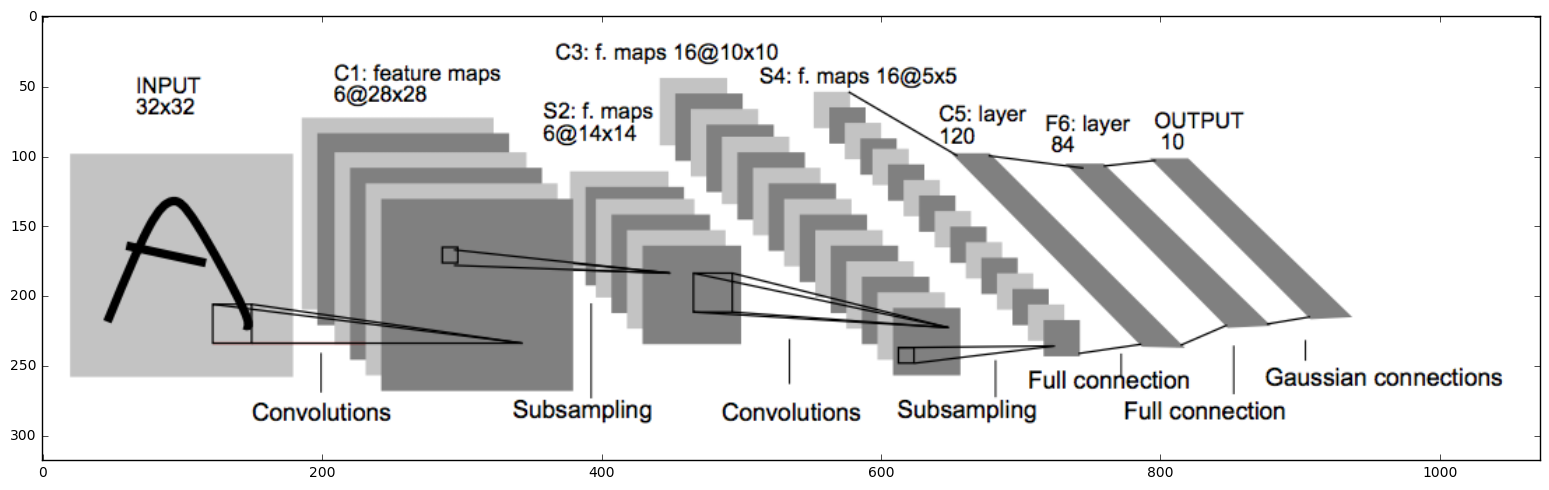

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

img = mpimg.imread('lenet.png')
plt.figure(figsize=(20, 5))
plt.imshow(img)
plt.tight_layout()
plt.show()

## Load Libraries

In [2]:
import cv2
import time
import math
import glob
import pickle
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm import tqdm
from sklearn.utils import shuffle
from tensorflow.contrib.layers import flatten
from sklearn.cross_validation  import StratifiedShuffleSplit
%matplotlib inline

import sys
print(sys.version)

from tensorflow.python.client import device_lib
print (device_lib.list_local_devices()[1].physical_device_desc,device_lib.list_local_devices()[1].name)

3.5.2 |Anaconda 4.2.0 (64-bit)| (default, Jul  5 2016, 11:41:13) [MSC v.1900 64 bit (AMD64)]
device: 0, name: GeForce GT 730M, pci bus id: 0000:01:00.0 /gpu:0


## Dataset Summary

In [3]:
training_file, validation_file, testing_file = 'train.p', 'valid.p', 'test.p'

with open(training_file, mode='rb') as f: train = pickle.load(f)
with open(validation_file, mode='rb') as f: valid = pickle.load(f)
with open(testing_file, mode='rb') as f: test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

print (train.keys(), X_train.shape)

dict_keys(['coords', 'sizes', 'labels', 'features']) (34799, 32, 32, 3)


**The pickled data is a dictionary with 4 key/value pairs:**  

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image.  

Note: These coordinates assume the original image  
Note: The pickled data contains resized version (32 by 32) of these images  

In [4]:
def display_summary_info():
    n_train = X_train.shape[0]
    n_valid = X_valid.shape[0]
    n_test = X_test.shape[0]
    image_shape = X_train.shape[:]
    class_names = pd.DataFrame(y_train)[0].unique()
    n_classes = len(class_names)
    print("Image data shape =", image_shape)
    print("Number of classes =", n_classes,'\n')
    print("Training examples =", n_train)
    print("Validation examples =", n_valid)
    print("Testing examples =", n_test,'\n')
    print('% Training =',np.round(100*n_train/(n_train+n_valid+n_test),0))
    print('% Validation =',np.round(100*n_valid/(n_train+n_valid+n_test),0))
    print('% Testing =',np.round(100*n_test/(n_train+n_valid+n_test),0))
    return class_names

if (1): class_names = display_summary_info()

Image data shape = (34799, 32, 32, 3)
Number of classes = 43 

Training examples = 34799
Validation examples = 4410
Testing examples = 12630 

% Training = 67.0
% Validation = 9.0
% Testing = 24.0


## Exploratory Visualisation

ref: [Matplotlib Gallery](matplotlib.org/gallery.html)  
ref: [Matplotlib Examples](matplotlib.org/examples/index.html)

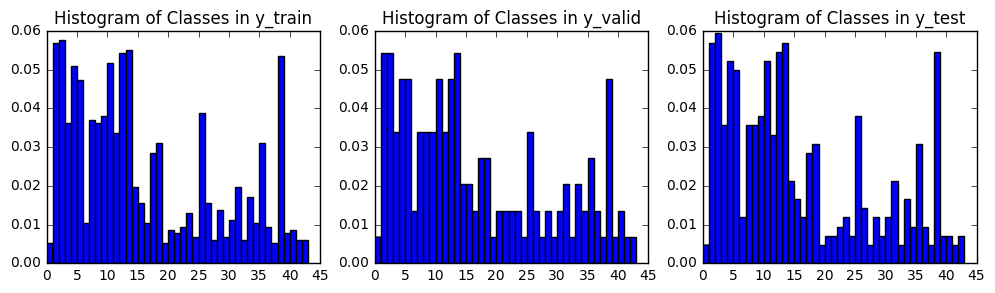

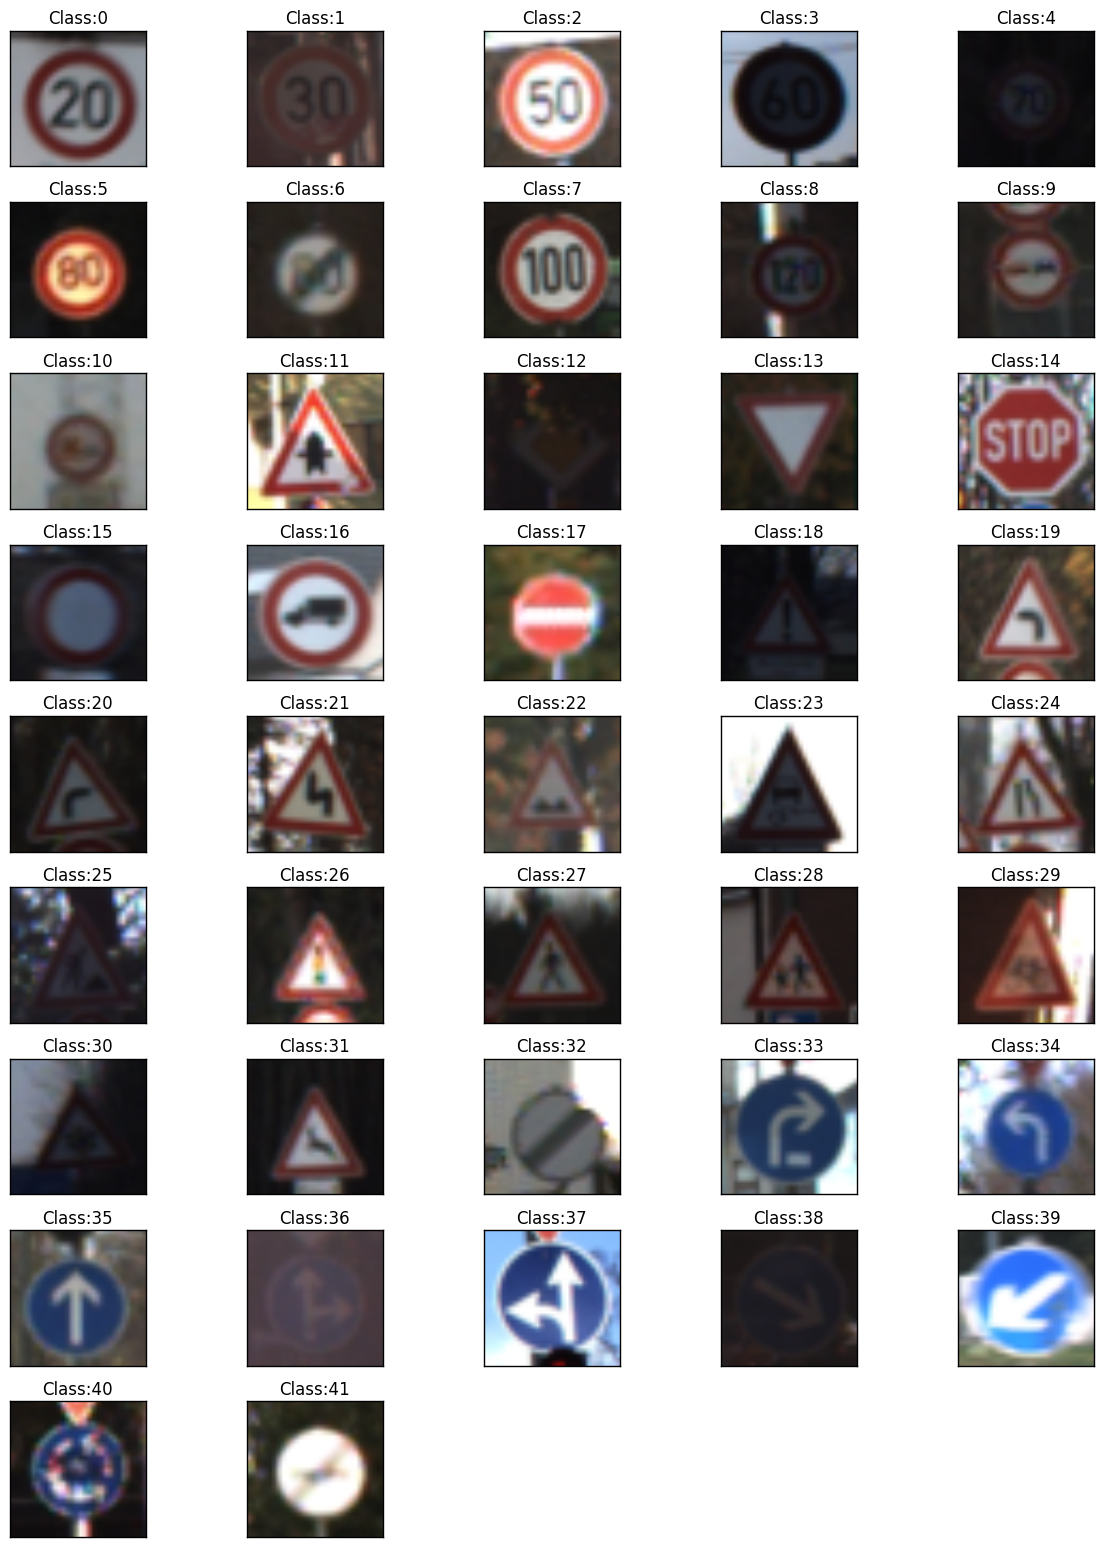

In [5]:
def plot_hist_visuals():
    fig = plt.figure(figsize=(12, 3))
    ax1 = fig.add_subplot(131)
    ax2 = fig.add_subplot(132)
    ax3 = fig.add_subplot(133)
    ax1.hist(y_train,bins=43,range=(0,43),align='mid',histtype="barstacked", normed=True)
    ax1.set_title("Histogram of Classes in y_train")
    ax2.hist(y_valid,bins=43,range=(0,43),align='mid',histtype="barstacked", normed=True)
    ax2.set_title("Histogram of Classes in y_valid")
    ax3.hist(y_test,bins=43,range=(0,43),align='mid',histtype="barstacked", normed=True)
    ax3.set_title("Histogram of Classes in y_test")

def plot_visuals(X_train,class_names):
    fig = plt.figure(figsize=(12,19))
    for j in range(len(class_names)-1):
        ax = fig.add_subplot(11, 5, j+1)
        index = np.random.choice(np.where(y_train==j)[0])
        ax.imshow(X_train[index],cmap='gray')
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
        plt.title('Class:'+str(j))
        plt.tight_layout()
    return None

if (1): plot_hist_visuals()
if (1): plot_visuals(X_train,class_names)     

## Preprocess Data
The datasets were rebalanced using Stratified Shuffle Split. This preprocessing technique randomly shuffles the data before splitting while preserving the percentage of samples for each class. The combined data was first split 80/20 for Train/Test datasets. The Train dataset was then further split 80/20 for Train / Valid for an overall split of 64/16/20 for Train / Valid / Test.

Rebalancing Classes...

Image data shape = (33179, 32, 32, 3)
Number of classes = 43 

Training examples = 33179
Validation examples = 8292
Testing examples = 10368 

% Training = 64.0
% Validation = 16.0
% Testing = 20.0


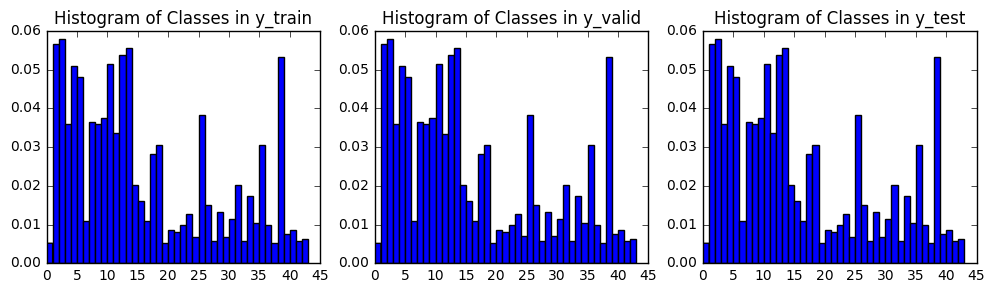

In [6]:
def rebalance_classes(X_train,X_valid,X_test,y_train,y_valid,y_test):
    '''
    Rebalances classes between datasets with Stratified Shuffle Split
    '''
    print ('Rebalancing Classes...\n')
    X_all = np.vstack((np.vstack((X_train, X_valid)), X_test))
    y_all = np.concatenate((y_train, y_valid, y_test))

    sss = StratifiedShuffleSplit(y=y_all, n_iter=3, test_size=0.2, random_state=0)

    for train_index, test_index in sss:
        X_train, X_test = X_all[train_index], X_all[test_index]
        y_train, y_test = y_all[train_index], y_all[test_index]

    X_all, y_all = X_train, y_train
    sss = StratifiedShuffleSplit(y=y_all, n_iter=3, test_size=0.2, random_state=0)    

    for train_index, test_index in sss:
        X_train, X_valid = X_all[train_index], X_all[test_index]
        y_train, y_valid = y_all[train_index], y_all[test_index]
        
    return X_train,X_valid,X_test,y_train,y_valid,y_test
    
if (1): X_train,X_valid,X_test,y_train,y_valid,y_test = rebalance_classes(X_train,X_valid,X_test,y_train,y_valid,y_test)
if (1): display_summary_info()
if (1): plot_hist_visuals()

## Feature Scaling
Feature Scaling was then performed with standardization by removing the mean and dividing by standard deviation.

In [7]:
def normalize(img):
    """
    Normalize and / or standardize images
    """
    new_img = np.copy(img)

    #a, b = 0.1, 0.9
    #scale_min, scale_max = 0.0, 255.0
    #new_img = a + (((img  - scale_min)*(b - a))/(scale_max - scale_min))
    #new_img = (new_img - 128.0) / 128.0
    #new_img = (new_img - np.mean(new_img)) / 128.0
    
    #new_img = (new_img - np.mean(new_img)) / (np.max(new_img) - np.min(new_img))
    new_img = (new_img - np.mean(new_img)) / np.std(new_img) ### try this
    
    return new_img

def test_normalize():
    q = np.copy(X_train[2])
    r = normalize(q)
    print (q.shape, np.mean(q[:,:,0]), np.mean(q[:,:,1]), np.mean(q[:,:,2]))
    print (r.shape, np.mean(r[:,:,0]), np.mean(r[:,:,1]), np.mean(r[:,:,2]),'\n')
    return None

before = np.mean(X_train)

if (1): test_normalize()
if (1): X_train, X_valid, X_test = normalize(X_train), normalize(X_valid), normalize(X_test)
    
after = np.mean(X_train)
print ('Done!', after)

(32, 32, 3) 84.0927734375 67.265625 66.1982421875
(32, 32, 3) 0.31548044105 -0.143192894323 -0.172287546727 

Done! -5.23038551431e-17


In [8]:
def pad_images(X_train,X_valid,X_test): 
    # NOTE: Images are already (32,32,3), so this function is not needed
    # LeNet architecture only accepts 32x32xC images, where C is the number of color channels.
    # Pads images with 0s: (28,28,3) --> (32,32,3) 
    
    X_train = np.pad(X_train, ((0,0),(2,2),(2,2),(0,0)), 'constant')
    X_valid = np.pad(X_valid, ((0,0),(2,2),(2,2),(0,0)), 'constant')
    X_test  = np.pad(X_test, ((0,0),(2,2),(2,2),(0,0)), 'constant')
    return X_train, X_valid, X_test 

#if (0): X_train, X_valid, X_test = pad_images(X_train,X_valid,X_test)

## Model Architecture
The LeNet-5 architecture was selected because it is small and easy to understand. 

**Input (32x32x3) ==> **  
**CONV (32x32x3) ==> RELU (28x28x6) ==> POOL (28x28x6) ==> **  
**CONV (14x14x6) ==> RELU (10x10x16) ==> POOL (10x10x16) ==> **  
**Flatten (5x5x16) ==> FC (400) ==> RELU (400) ==> FC (120) ==> RELU (84) ==> FC (84) ==> Output (43) **

In [18]:
def LeNet(x):    
    mu = 0.01 # 0.00
    sigma = 0.10 # 0.10
    
    # CNN 1: 32x32x3 ==> 28x28x6 (Convolutional Neural Network)
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Act 1: 28x28x6 ==> 28x28x6, Pooling 1: 28x28x6 ==> 14x14x6
    conv1 = tf.nn.relu(conv1)
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
   
    # CNN 2: 14x14x6 ==> 10x10x16 (Convolutional Neural Network)
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Act 2: 10x10x16 ==> 10x10x16, Pooling 2: 10x10x16 ==> 5x5x16
    conv2 = tf.nn.relu(conv2)
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
 
    # Flatten: 5x5x16 ==> 400.
    fc0   = flatten(conv2)
        
    # FC 1: 400 ==> 120 (Fully Connected)
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Act 1: 120 ==> 120 
    fc1    = tf.nn.relu(fc1)
    
    # FC 2: 120 ==> 84 (Fully Connected)
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Act 2: 84 to 84.
    fc2    = tf.nn.relu(fc2)

    # FC 2: 84 ==> 43 (Fully Connected)
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))  # *** 43 ***.
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

In [19]:
x = tf.placeholder(tf.float32, (None, 32, 32, 3)) 
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, len(class_names)) 

In [20]:
EPOCHS = 15
BATCH_SIZE = 128
rate = 0.001 # try 0.001

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [21]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

## Model Training and Solution Approach
The Adam Optimizer was selected because it has been shown to outperform Stochastic Gradient Descent (SGD) on a wide range of non-convex optimization problems in machine learning. Previous experience with Deep Learning for Kaggle Competitions has shown that Batch Size of 128 provides a good balance between accuracy and training time. Changes to Training Rate and Sigma were not found to show any improvements for accuracy.

**Initial Parameters:**   

**Optimizer = Adam**  
**Batch Size = 128**  
**Training Rate = 0.001**  
**Rebalance = NO**  
**Normalize = NO**   
**Mu = 0.0**  
**Sigma = 0.1**  
**Epochs = 15**   

**Rebalancing the Datasets** with Stratified Shuffle Split provided the single greatest improvement **(increasing Validation Accuracy from 88.3% to 97.7%)**. **Normalizing the Datasets** did not further improve accuracy, but did increase the accuracy and confidence **(increasing probability for selected class)**. Slightly offsetting the mean for initial weights (0.00 to 0.01) showed another small improvement **(increasing Validation Accuracy from 97.7% to 98.6%) for some model runs**.  

The Final Deep Learning Model was able to exceed the Validation Accuracy goal **(93.0%)** with only 3 Epochs **(93.7%)**.  

**Final Parameters:**  

**Optimizer = Adam**  
**Batch Size = 128**  
**Training Rate = 0.001**  
**Rebalance = YES**  
**Normalize = YES**   
**Mu = 0.01**  
**Sigma = 0.1**  
**Epochs = 15**  

Training...

EPOCH 1 ...
Validation Accuracy = 0.803

EPOCH 2 ...
Validation Accuracy = 0.924

EPOCH 3 ...
Validation Accuracy = 0.937

EPOCH 4 ...
Validation Accuracy = 0.962

EPOCH 5 ...
Validation Accuracy = 0.970

EPOCH 6 ...
Validation Accuracy = 0.973

EPOCH 7 ...
Validation Accuracy = 0.971

EPOCH 8 ...
Validation Accuracy = 0.975

EPOCH 9 ...
Validation Accuracy = 0.980

EPOCH 10 ...
Validation Accuracy = 0.982

EPOCH 11 ...
Validation Accuracy = 0.976

EPOCH 12 ...
Validation Accuracy = 0.969

EPOCH 13 ...
Validation Accuracy = 0.980

EPOCH 14 ...
Validation Accuracy = 0.983

EPOCH 15 ...
Validation Accuracy = 0.977

Model saved
243.16 Seconds for Deep Learning..
Done!



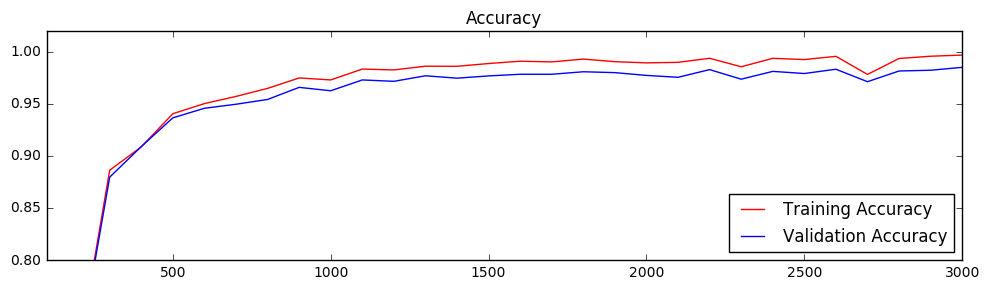

Test Accuracy = 0.977


In [22]:
log_batch_step = 100 # 50
batches = []
loss_batch = []
train_acc_batch = []
valid_acc_batch = []

def deep_learning_model(X_train,y_train,X_valid,y_valid):
    t=time.time()
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        num_examples = len(X_train)
    
        print("Training...")
        print()
        for i in range(EPOCHS):
            X_train, y_train = shuffle(X_train, y_train)
            batch_count = 0
            for offset in range(0, num_examples, BATCH_SIZE):
                batch_count += 1
                end = offset + BATCH_SIZE
                batch_x, batch_y = X_train[offset:end], y_train[offset:end]
                sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
                if batch_count % log_batch_step == 0:
                    previous_batch = batches[-1] if batches else 0
                    batches.append(log_batch_step + previous_batch)
                    training_accuracy = evaluate(X_train, y_train)  
                    validation_accuracy = evaluate(X_valid, y_valid) 
                    train_acc_batch.append(training_accuracy)
                    valid_acc_batch.append(validation_accuracy)
                
            #training_accuracy = evaluate(X_train, y_train) 
            validation_accuracy = evaluate(X_valid, y_valid)
            print("EPOCH {} ...".format(i+1))
            print("Validation Accuracy = {:.3f}".format(validation_accuracy))
            print()
        
        saver.save(sess, './lenet')
        print("Model saved")
    
    t2 = time.time()
    print (round(t2-t, 2), 'Seconds for Deep Learning..')
    print ('Done!\n')
    
    return batches, train_acc_batch, valid_acc_batch

def display_accuracy(batches,train_acc_batch,valid_acc_batch):
    fig = plt.figure(figsize=(10,3))
    plt.title('Accuracy')
    plt.plot(batches, train_acc_batch, 'r', label='Training Accuracy')
    plt.plot(batches, valid_acc_batch, 'b', label='Validation Accuracy')
    plt.ylim([0.8, 1.02])
    plt.xlim([batches[0], batches[-1]])
    plt.legend(loc=4)
    plt.tight_layout()
    plt.show()
    return None

if (1): deep_learning_model(X_train,y_train,X_valid,y_valid)
if (1): display_accuracy(batches,train_acc_batch,valid_acc_batch)
    
if (1): # calculate testing accuracy
    with tf.Session() as sess:
        saver.restore(sess, tf.train.latest_checkpoint('.'))
        test_accuracy = evaluate(X_test, y_test)
        print("Test Accuracy = {:.3f}".format(test_accuracy))

## Acquiring New Images

Google was searched for additional test images for German Traffic signs. The first 3 were images were selected to be Easy Images since they are centered with good color and lighting. The next 3 images were selected to be Hard Images. **Hard Image #1** is slightly offset with half of another sign. **Hard Image #2** is dark with sign tilting backwards and blurred "Getty Images" text near the base. **Hard Image #3** has full images of "Yield" and "Roundabout Mandatory".  

**Easy Image #1: Stop Sign, Class 14**  
**Easy Image #2: Speed limit (60km/h), Class 3**  
**Easy Image #3: Roundabout Mandatory, Class 40**  

**Hard Image #1: No Entry, Class 17**  
**Hard Image #2: Speed limit (20km/h), Class 0**  
**Hard Image #3: Yield, Class 13 and Roundabout Mandatory, Class 40 **

3.5.2 |Anaconda 4.2.0 (64-bit)| (default, Jul  5 2016, 11:41:13) [MSC v.1900 64 bit (AMD64)]
device: 0, name: GeForce GT 730M, pci bus id: 0000:01:00.0 /gpu:0


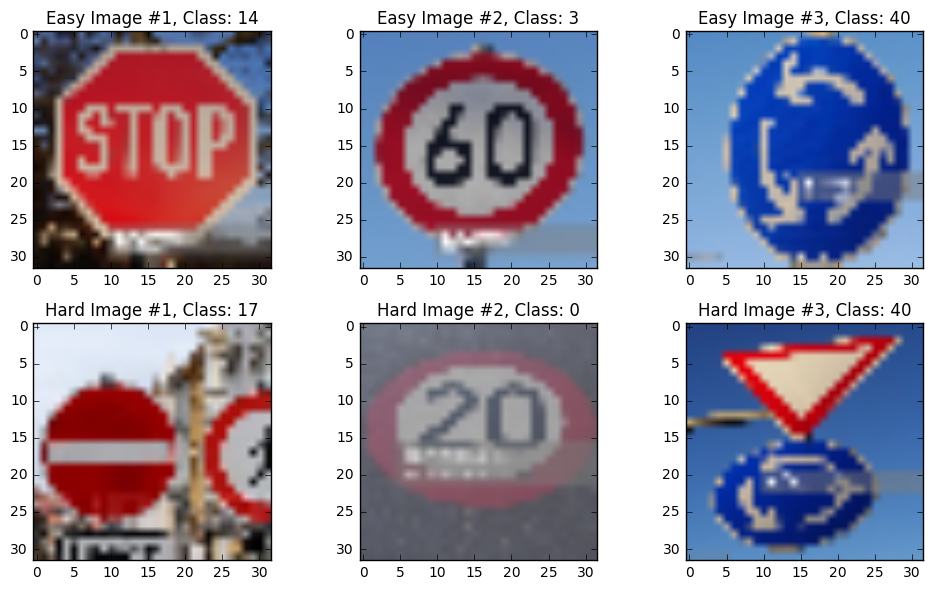

In [14]:
test_signs = glob.glob('./test_images/*')
X_signs = []

sign_names = pd.read_csv('signnames.csv')
y_sign_desc = sign_names['SignName']

y_signs = [14,3,40,17,0,40]

for i in range(len(test_signs)):
    img = mpimg.imread(test_signs[i])
    img = cv2.resize(img, (32,32))   
    X_signs.append(img)

def plot_test_signs(X_signs):
    plt.figure(figsize=(10,6))
    plt.subplot(231)
    plt.title('Easy Image #1, Class: '+ str(y_signs[0]))
    plt.imshow(X_signs[0])
    plt.subplot(232)
    plt.title('Easy Image #2, Class: '+ str(y_signs[1]))
    plt.imshow(X_signs[1])   
    plt.subplot(233)
    plt.title('Easy Image #3, Class: '+ str(y_signs[2]))
    plt.imshow(X_signs[2])    
    plt.subplot(234)
    plt.title('Hard Image #1, Class: '+ str(y_signs[3]))
    plt.imshow(X_signs[3])
    plt.subplot(235)
    plt.title('Hard Image #2, Class: '+ str(y_signs[4]))
    plt.imshow(X_signs[4])
    plt.subplot(236)
    plt.title('Hard Image #3, Class: '+ str(y_signs[5]))
    plt.imshow(X_signs[5])
    plt.tight_layout()
    plt.show()
    return None

plot_test_signs(X_signs)

## Performance on New Images
The Deep Learning Model performed very well with the New Images. 3/3 of the Easy Images (100%) were classified correctly. 2/3 of the Hard Images were classified correctly (67%). The Hard Images were selected to be very difficult and present unique challenges to the model, so the overall Validation Accuracy for the New Images (83%) compares favorably to that of the Test Set (98.5%).

In [15]:
X_signs_new = normalize(X_signs)

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    test_accuracy = evaluate(X_signs_new, y_signs)
    print("Test Accuracy = {:.3f}".format(test_accuracy))
    prediction = tf.argmax(logits, 1)

    test_prediction = sess.run(
        prediction,
        feed_dict={x: X_signs_new})
    
print (test_prediction)
print ()
for i in range(len(test_prediction)):
    print ('Prediction:', y_sign_desc[test_prediction[i]], test_prediction[i])
    
print ()
print ('100% accuracy on Easy images (3/3) - TOP ROW')
print ('67% accuracy on Hard Images (2/3) - BOTTOM ROW')

Test Accuracy = 0.833
[14  3 40 17 38 40]

Prediction: Stop 14
Prediction: Speed limit (60km/h) 3
Prediction: Roundabout mandatory 40
Prediction: No entry 17
Prediction: Keep right 38
Prediction: Roundabout mandatory 40

100% accuracy on Easy images (3/3) - TOP ROW
67% accuracy on Hard Images (2/3) - BOTTOM ROW


## Model Certainty - Softmax Probabilities

**Easy Image #1: Stop Sign, Class 14 ==> Class 14 (100%) ==> YES**  
**Easy Image #2: Speed limit (60km/h), Class 3 ==> Class 3 (99.2%) ==> YES**  
**Easy Image #3: Roundabout Mandatory, Class 40 ==> Class 40 (100%) ==> YES**  

**Hard Image #1: No Entry, Class 17 ==> Class 17 (100%) ==> YES**  
**Hard Image #2: Speed limit (20km/h), Class 0 ==> Class 38 (66.7%) ==> NO **  
**Hard Image #3: Yield, Class 13 and Roundabout Mandatory, Class 40 ==> Class 40 (99.9%) ==> YES **

Overall the Deep Learning Model is very confident, with 5/6 correct predictions with probabilities over 99.9%. The only uncertainty was with Hard Image #2 and that image was classified incorrectly. Interestingly, the model could have correctly selected either Class 13 or Class 40 for Hard Image #3, but selected Class 40 with 99.9% confidence. 

In [16]:
k = 5

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    test_accuracy = evaluate(X_signs_new, y_signs)
    
    prediction = tf.nn.softmax(logits)

    test_prediction = sess.run(tf.nn.top_k(
        prediction,k=k),
        feed_dict={x: X_signs_new})
    
probabilities, test_prediction = test_prediction

# verify output
print (probabilities)
print ()
print (test_prediction)

[[  1.00000000e+00   2.37605935e-09   9.86190907e-10   1.89800237e-12
    9.51168072e-13]
 [  9.91813898e-01   6.76383451e-03   1.42221851e-03   8.82773588e-09
    3.51740284e-13]
 [  1.00000000e+00   4.14929133e-11   5.24317222e-12   5.99077684e-17
    3.99039835e-17]
 [  1.00000000e+00   3.54759315e-08   1.14807415e-12   1.44412104e-14
    9.04476392e-16]
 [  6.67355716e-01   3.19307595e-01   1.25019215e-02   4.16143303e-04
    1.06170031e-04]
 [  9.99665499e-01   3.31293675e-04   2.91174956e-06   1.33130897e-07
    1.08977090e-07]]

[[14 17  1  0  3]
 [ 3  2  5  1  6]
 [40 30 38 34 41]
 [17 30 11 10 40]
 [38 22 20 30 40]
 [40 30 10  5 37]]


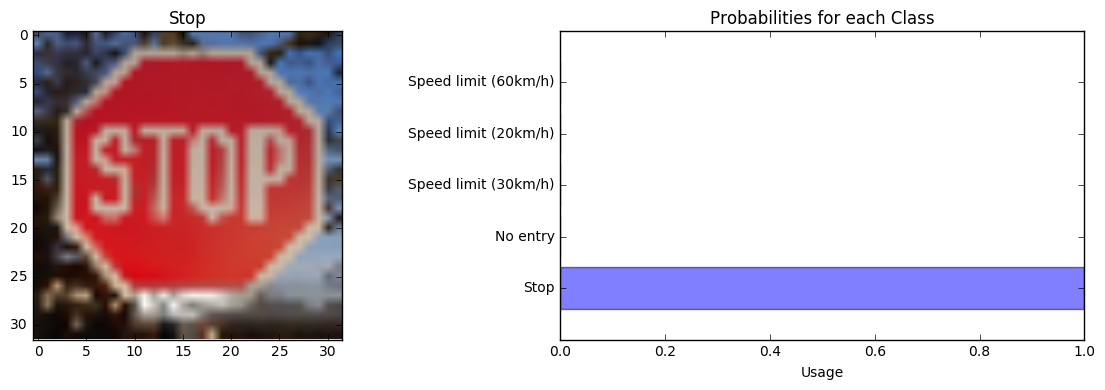

Prediction: [14 17  1  0  3]
Probability [  1.0000e+00   2.3761e-09   9.8619e-10   1.8980e-12   9.5117e-13]



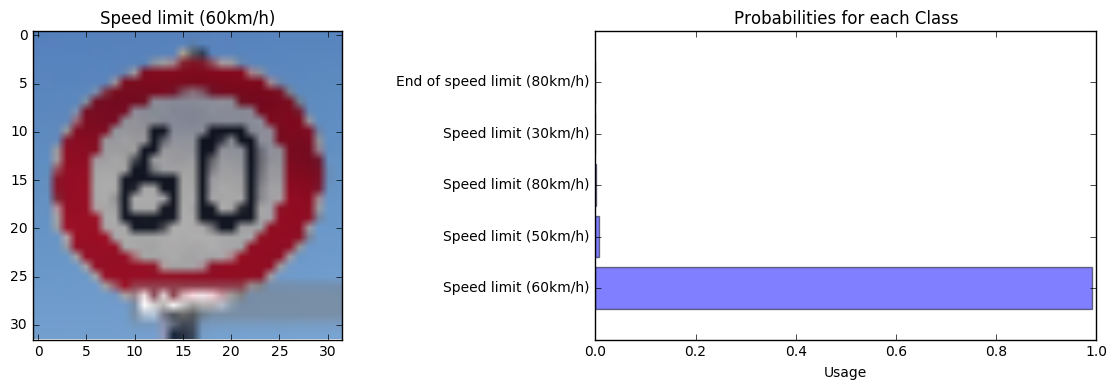

Prediction: [3 2 5 1 6]
Probability [  9.9181e-01   6.7638e-03   1.4222e-03   8.8277e-09   3.5174e-13]



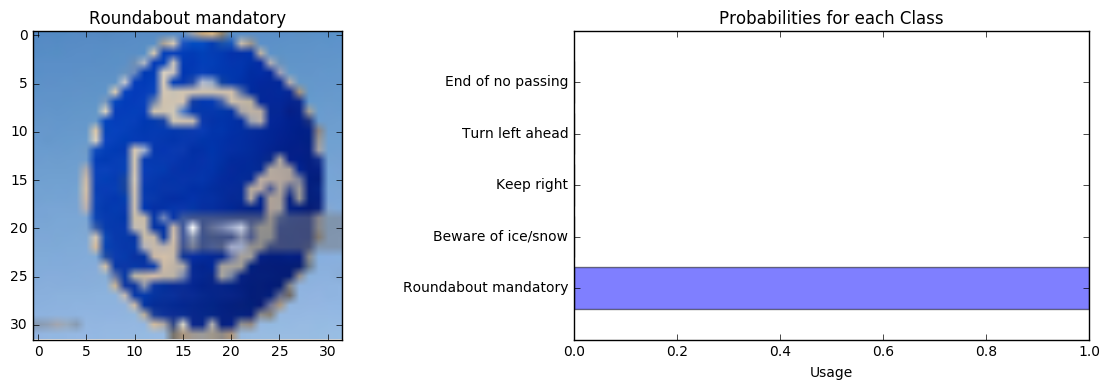

Prediction: [40 30 38 34 41]
Probability [  1.0000e+00   4.1493e-11   5.2432e-12   5.9908e-17   3.9904e-17]



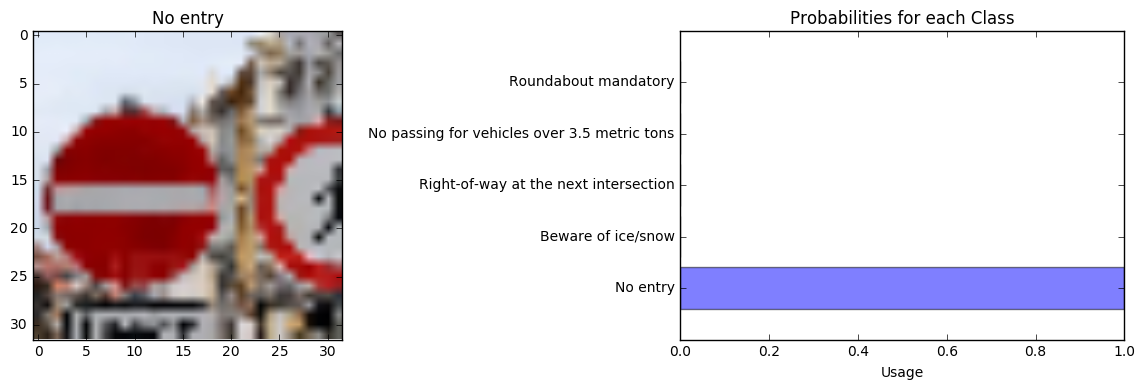

Prediction: [17 30 11 10 40]
Probability [  1.0000e+00   3.5476e-08   1.1481e-12   1.4441e-14   9.0448e-16]



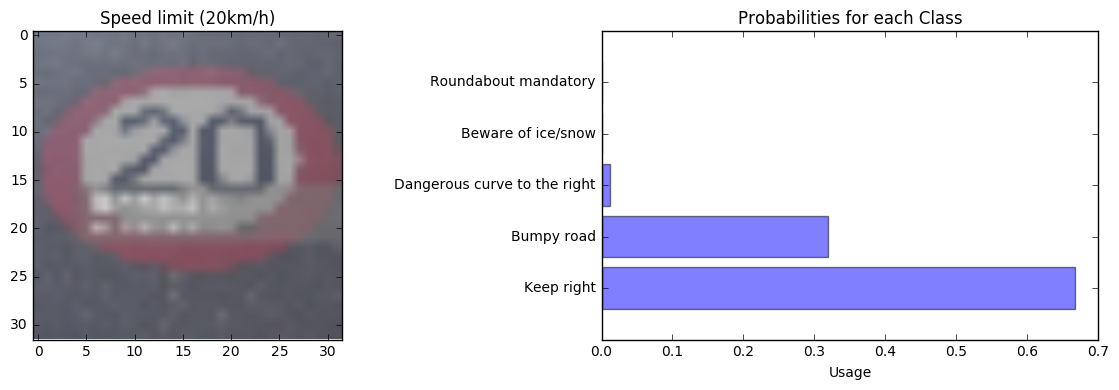

Prediction: [38 22 20 30 40]
Probability [  6.6736e-01   3.1931e-01   1.2502e-02   4.1614e-04   1.0617e-04]



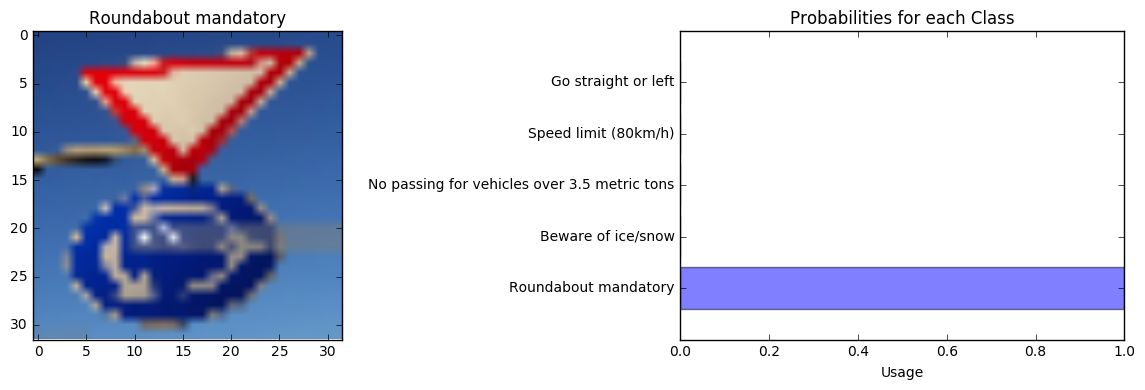

Prediction: [40 30 10  5 37]
Probability [  9.9967e-01   3.3129e-04   2.9117e-06   1.3313e-07   1.0898e-07]



In [17]:
np.set_printoptions(precision=4)

for i in range(len(X_signs_new)):
    prediction = test_prediction[i]
    performance = probabilities[i]
    objects = []
    for j in range(k): objects.append(y_sign_desc[prediction[j]])
    y_pos = np.arange(len(objects))

    plt.figure(figsize=(12,4))
    plt.subplot(121)
    plt.imshow(X_signs[i])
    plt.title(y_sign_desc[y_signs[i]])
    plt.subplot(122)
    plt.barh(y_pos, performance, align='center', alpha=0.5)
    plt.yticks(y_pos, objects)
    plt.xlabel('Usage')
    plt.title('Probabilities for each Class')
    plt.tight_layout()
    plt.show()    
    print ('Prediction:',prediction)
    print ('Probability', performance)
    print ()

## Discussion
The biggest challenge was installing and using TensorFlow GPU on my laptop. The GeForce GT 730M is a couple of years old would crash with more than one Python kernel or Jupyter Notebook open. It took a little while to figure this out. 

I’m very happy with the results of this project. Possible improvements that I can think of include: (1) equalizing the number of sample in each class, (2) augmenting the data with skew, perspective and rotational transforms, (3) implementing dropout, (4) and refactoring the code with Nervana's Neon Deep Learning Framework.